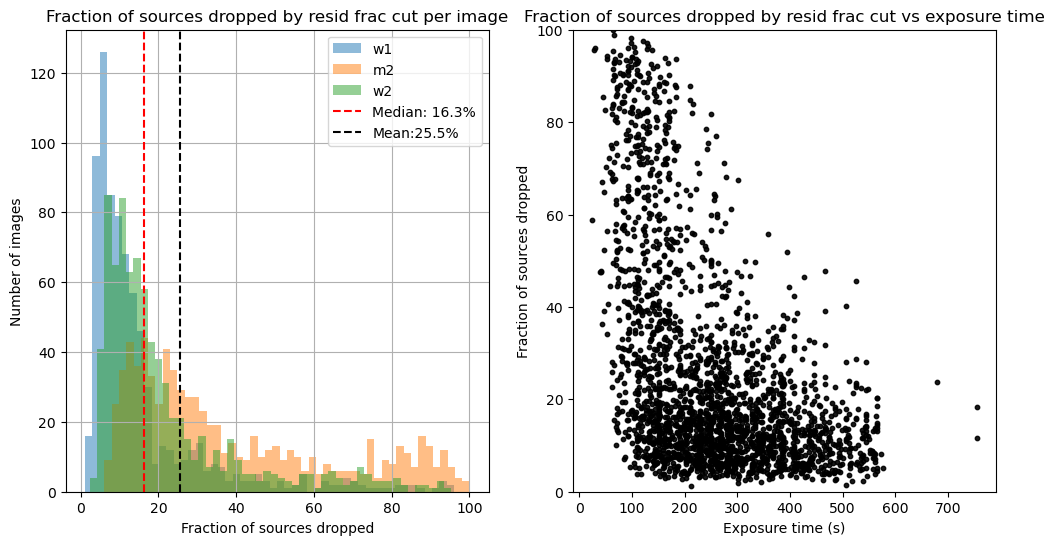

In [ ]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
data_dir = os.getenv("DATADIR")
log_dir = data_dir + "0_SUMS_Catalogs/Logs/"

# Grab everything during step 3 before resid frac cut, combine and separate into what was cut and what wasn't. 

run_combine = False
run_fraction = False
if run_combine: 
    files = glob.glob(log_dir+'*resid_frac_TOTAL.csv')
    cols = ['Ra', 'Dec',  'Umag', 'e_Umag', 'Bmag', 'e_Bmag', 'Vmag', 'e_Vmag', 'Imag', 'e_Imag', 'filename', 'exposure','uvfilter','RESID_FRAC']
    # Open all and combine into one df
    dfs = []
    for f in files:
        uvf = f.split('/')[-1].split('uv')[1].split('_')[0]
        df = pd.read_csv(f)
        # Add uvfilter column
        df['uvfilter'] = uvf
        # Reduce file size somewhat 
        df = df[cols]
        dfs.append(df)

    df = pd.concat(dfs)
    df = df.reset_index(drop=True)
    df['tag_id'] = [f'ind_{i}' for i in range(df.shape[0])]
    df['full_name'] = df['filename'].values + '_' + df['uvfilter'].values + '_' + df['exposure'].values.astype(str)
    df.to_csv(data_dir + '0_SUMS_Catalogs/Logs/combined_TOTAL.csv', index=False)
    dropped = df[df['RESID_FRAC'] >= 0.3].reset_index(drop=True).to_csv(data_dir + '0_SUMS_Catalogs/Logs/combined_dropped.csv', index=False)

# Per image, how many sources are typically dropped because of the resid frac cut?

if run_fraction:
    df = pd.read_csv(data_dir + '0_SUMS_Catalogs/Logs/combined_TOTAL.csv')
    dropped = pd.read_csv(data_dir + '0_SUMS_Catalogs/Logs/combined_dropped.csv')
    unique_fnames = df['full_name'].unique()
    n_all = []
    n_dropped = []
    uv_filters = []
    exposures = []
    for fname in unique_fnames:
        full = df[df['full_name'] == fname]
        lost = dropped[dropped['full_name'] == fname].shape[0]
        n_all.append(full.shape[0])
        n_dropped.append(lost)
        uv_filters.append(full['uvfilter'].values[0])
        exposures.append(full['exposure'].values[0])
    n_frac = np.array(n_dropped) / np.array(n_all) * 100
    meta = pd.DataFrame({'fname': unique_fnames, 'uvfilter':uv_filters,'exposure':exposures,'n_all': n_all, 'n_dropped': n_dropped, 'fraction': n_frac})
    meta.to_csv(data_dir + '0_SUMS_Catalogs/Logs/combined_meta.csv', index=False)

# Visualize as a histogram

else:
    meta = pd.read_csv(data_dir + '0_SUMS_Catalogs/Logs/combined_meta.csv')
    f, axes = plt.subplots(1, 2, figsize=(12, 6))
    for uvf in meta['uvfilter'].unique():
        sub = meta[meta['uvfilter'] == uvf]
        sub['fraction'].hist(bins=50,label=uvf, alpha=0.5, ax=axes[0])
    axes[0].set_ylabel('Number of images')
    axes[0].set_xlabel('Fraction of sources dropped')
    axes[0].axvline(x=meta['fraction'].median(), color='r', linestyle='--', label=f'Median: {meta["fraction"].median():.1f}%')
    axes[0].axvline(x=meta['fraction'].mean(), color='k', linestyle='--', label=f'Mean:{meta["fraction"].mean():.1f}%')
    axes[0].legend()
    axes[0].set_title('Fraction of sources dropped by resid frac cut per image')
    # Plot fraction vs exposure 
    axes[1].scatter(meta['exposure'], meta['fraction'], alpha=0.9, c='k', s=10)
    axes[1].set_ylim(0, 100)
    axes[1].set_xlabel('Exposure time (s)')
    axes[1].set_ylabel('Fraction of sources dropped')
    axes[1].set_title('Fraction of sources dropped by resid frac cut vs exposure time')